In [1]:
import os
import math
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import (
    create_img_grid,
    SpatialProjection
)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
data_dir = "../../data/dataset/raw/"
subjects = os.listdir(data_dir)

sp = SpatialProjection(
    img_dir="../../data/dataset/images/",
    img_len=math.floor(config.IMG_LEN / 3),
    polyfit_degree=7
)


In [3]:
images = []
labels = []

for subject in subjects:
    for gesture in config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            _images = []
            file_path = os.path.join(gesture_dir, recording)

            data = pd.read_csv(file_path)
            data.drop(columns=["time"], inplace=True)
            data.drop(0, inplace=True)  # Remove first All-0 row

            for landmark in config.PROJECTION_LANDMARKS:
                _images.extend(
                    sp.get_projection_images(
                        data=data.filter(regex=landmark),
                        subject=subject,
                        gesture=gesture
                    )
                )

            img = create_img_grid(_images)

            images.append(img)
            labels.append(config.GESTURES.index(gesture))

            # plt.imshow(img)
            # plt.show()

            # break
    #     break
    # break


In [4]:
X = np.array(images, dtype="uint8")
# X = np.expand_dims(X[:, :, :, 0], axis=-1)
# X = np.repeat(np.expand_dims(X, axis=-1), 3, axis=-1)
y = np.array(labels, dtype="uint8")

print(X.shape)
print(y.shape)

(139, 224, 224, 3)
(139,)


In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

2022-06-14 20:16:08.099438: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(config.IMG_LEN, config.IMG_LEN, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(config.GESTURES))

inputs = tf.keras.Input(shape=(config.IMG_LEN, config.IMG_LEN, 3))
x = preprocess_input(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


2022-06-14 20:16:09.146402: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-14 20:16:09.146427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Andromeda
2022-06-14 20:16:09.146431: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Andromeda
2022-06-14 20:16:09.146568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-06-14 20:16:09.146582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-06-14 20:16:09.146585: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-06-14 20:16:09.146927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

In [8]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Rescaling(
#         1/255.0,
#         input_shape=(config.IMG_LEN, config.IMG_LEN, config.N_CHANNELS)
#     ),
#     tf.keras.layers.Conv2D(8, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(8, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(len(config.GESTURES))
# ])


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=700,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/700
3/3 [==============================] - 7s 2s/step - loss: 2.7733 - accuracy: 0.1720 - val_loss: 2.0579 - val_accuracy: 0.3261
Epoch 2/700
3/3 [==============================] - 4s 2s/step - loss: 1.0781 - accuracy: 0.6989 - val_loss: 1.5348 - val_accuracy: 0.6087
Epoch 3/700
3/3 [==============================] - 5s 2s/step - loss: 0.5194 - accuracy: 0.9247 - val_loss: 1.1836 - val_accuracy: 0.7174
Epoch 4/700
3/3 [==============================] - 5s 2s/step - loss: 0.2689 - accuracy: 0.9677 - val_loss: 0.9143 - val_accuracy: 0.7826
Epoch 5/700
3/3 [==============================] - 5s 2s/step - loss: 0.1075 - accuracy: 1.0000 - val_loss: 0.7708 - val_accuracy: 0.7826
Epoch 6/700
3/3 [==============================] - 5s 2s/step - loss: 0.0630 - accuracy: 1.0000 - val_loss: 0.6725 - val_accuracy: 0.8043
Epoch 7/700
3/3 [==============================] - 4s 2s/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.6104 - val_accuracy: 0.8261
Epoch 8/700
3/3 [=================

In [11]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 295ms/step - loss: 0.3889 - accuracy: 0.8913


[0.3889082968235016, 0.8913043737411499]

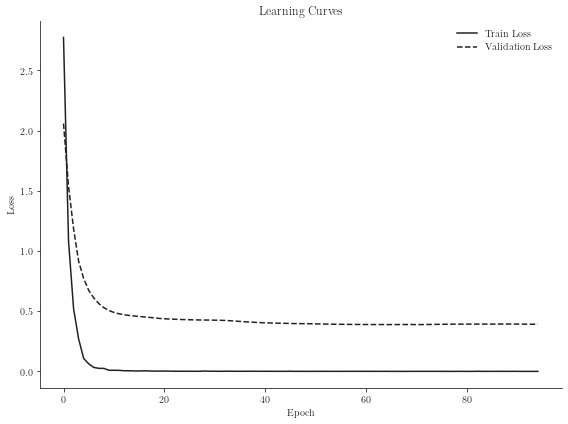

In [12]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["loss"], "-", color="#212121", label="Train Loss")
ax.plot(history.history["val_loss"], "--",
        color="#212121", label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/lc.png")
plt.show()


In [13]:
tf.keras.backend.clear_session()
